In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
# Load the data
# Assuming the CSV file is in the current directory with the name 'banana_index.csv'
df = pd.read_csv('bananaindex.csv')

# Handle categorical variables using one-hot encoding if needed
df = pd.get_dummies(df, drop_first=True)

# Explore the data to understand it better
print(df.head())

X = df[['land_use_kg', 'land_use_1000kcal', 'Land use per 100 grams of protein', 'Land use per 100 grams of fat']].values  # Assuming 'land_use' is the name of your feature column
y = df[['Bananas index (kg)', 'Bananas index (1000 kcalories)', 'Bananas index (100g protein)']].values  # Replace with actual column names

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # or median, or most_frequent
X_imputed = imputer.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

   year  emissions_kg  emissions_1000kcal  emissions_100g_protein  \
0  2022      0.488690            0.317338                0.878525   
1  2022      0.387011            0.067265                0.207599   
2  2022      0.655888            2.222230               13.595512   
3  2022      0.602368            0.105029                0.328335   
4  2022      0.458378            0.955184               29.152212   

   emissions_100g_fat  land_use_kg  land_use_1000kcal  \
0            2.424209     0.811485           0.601152   
1            0.079103     7.683045           1.296870   
2            4.057470     1.370106           2.675063   
3            0.119361     8.230927           1.423376   
4           19.754980     0.660629           1.382839   

   Land use per 100 grams of protein  Land use per 100 grams of fat  \
0                           1.577687                       3.065766   
1                           3.608433                       1.495297   
2                          12

## Linear Regression

R-squared for the 1 target: 0.9562964971989433
R-squared for the 2 target: 0.8725734065893976
R-squared for the 3 target: 0.5261166929924412


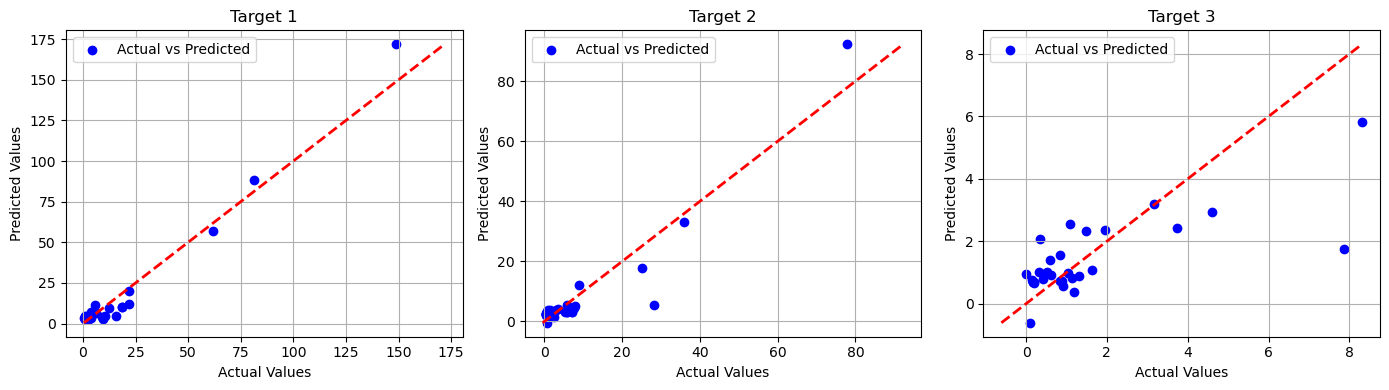

In [3]:
# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R-squared for the first target
for r in range(3):
    r2 = r2_score(y_test[:, r], y_pred[:, r])
    print(f'R-squared for the {r + 1} target: {r2}')

# If you want to visualize the results, you will need to plot each target separately.
# Here is an example of how you might plot the results for the first target.
plt.figure(figsize=(14, 4))

for i in range(y.shape[1]):
    plt.subplot(1, y.shape[1], i+1)
    plt.scatter(y_test[:, i], y_pred[:, i], color='blue', label='Actual vs Predicted')
    plt.title(f'Target {i+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    # Plotting the diagonal line
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# # Save the model for future use
# import joblib
# joblib.dump(model, 'banana_index_predictive_model.pkl')

## Random Forest Regression Model

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Train the model on training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_r2 = r2_score(y_test, y_pred_rf)
print("Random Forest R-squared for test set: {:.3f}".format(rf_r2))

Random Forest R-squared for test set: 0.727


## Grid Search Model

In [10]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # Number of folds for cross-validation
                           verbose=2,  # Controls the verbosity: the higher, the more messages
                           n_jobs=-1)  # Number of jobs to run in parallel

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and associated model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best parameters from grid search: ", best_params)

# Predict and evaluate using the best model
y_pred_best_rf = best_rf_model.predict(X_test)
best_rf_r2 = r2_score(y_test, y_pred_best_rf)
print("Best Random Forest R-squared for test set: {:.3f}".format(best_rf_r2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from grid search:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}
Best Random Forest R-squared for test set: 0.687


## Pipe Line 

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# A pipeline with StandardScaler and the best RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(**best_params, random_state=42))  # Using best_params found from grid search
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred_pipeline = pipeline.predict(X_test)

# Evaluate the model using the pipeline
pipeline_r2 = r2_score(y_test, y_pred_pipeline)
print("Pipeline R-squared for test set: {:.3f}".format(pipeline_r2))

Pipeline R-squared for test set: 0.687


## Feature Importance Visualization for RandomForestRegressor

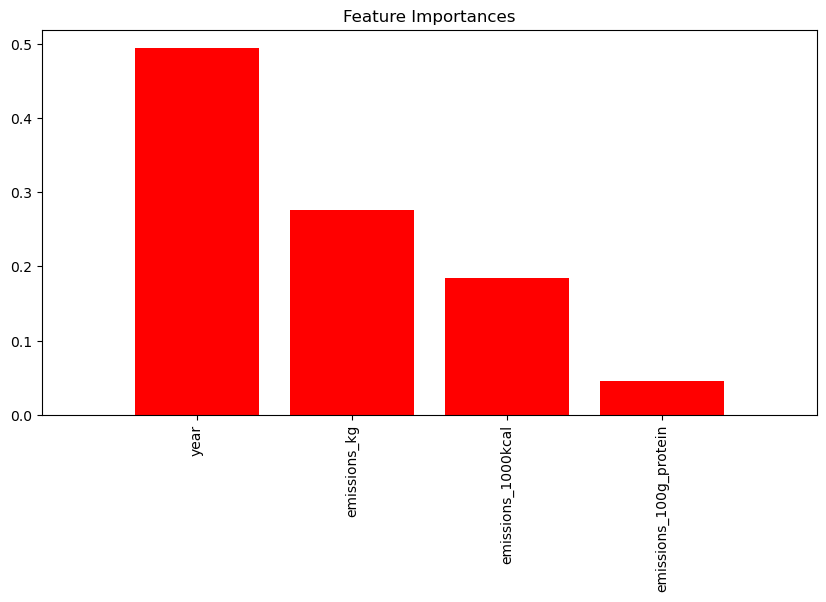

In [12]:
# Feature importance for RandomForestRegressor
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = df.columns[:len(importances)]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
import seaborn as sns

# Heatmap for GridSearchCV results
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(index='param_n_estimators',
                                  columns='param_max_depth',
                                  values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title("Grid Search R-squared Scores")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()